In [1]:
# Importing google drive
from google.colab import drive
drive.mount('content/', force_remount = True)

FOLDERNAME = "vehicle-re-identification"

import sys
sys.path.append('content/MyDrive/{}'.format(FOLDERNAME))
path = 'content/MyDrive/{}'.format(FOLDERNAME)

Mounted at content/


In [2]:
!pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

     / 3.1MB 2.8MB/s
  Created wheel for POT: filename=POT-0.8.0.dev0-cp37-cp37m-linux_x86_64.whl size=331117 sha256=f65249e4eed2595dee711169c99d1bac3eba5110b12db199605e9ed6a1d9c232
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbx7k8tz/wheels/93/0c/d1/8e19e3f5c79674eb251274c76a2b1b9b429e7756d8a9465027
Successfully built POT


In [3]:
import os

# PyTorch
import torch
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Importing local files
import constants as c
from model.losses import OtLoss, ClfLoss 
from dataloader.dataloader import load_dataset, DataloaderIterator, SourceTargetIterator
from model.net import FeatExt, ClfModel
from training.train import train_model_, process_source_one_epoch, process_target_one_epoch
from utils import DataLogger

%load_ext autoreload
%autoreload 2

In [4]:
def imshow(inp, title=None, norm=True):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
# Global Variables
c.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
c.batch_size = 128
c.eval_every = 1

In [6]:
# Create the dataset
source_cam = ['c001', 'c002', 'c006', 'c010', 'c011',
              'c013', 'c014', 'c015', 'c017', 'c019']
target_cam = ['c003', 'c004', 'c005', 'c007', 'c008', 'c009', 'c012', 'c016']

#source_cam = ['c001']
#target_cam = ['c003']
source_train_gen, source_test_gen, source_val_gen, \
target_train_gen, target_test_gen, target_val_gen = load_dataset(c.veri_root,
                                                                 source_cam,
                                                                 target_cam)

dataset_size = {'source_train': len(source_train_gen),
                'source_test': len(source_test_gen),
                'source_val': len(source_val_gen),
                'target_train': len(target_train_gen),
                'target_test': len(target_test_gen),
                'target_val': len(target_val_gen)}

# Create the dataloader
source_loader = {'train': DataLoader(source_train_gen, shuffle=True, drop_last=True, 
                                     batch_size=c.batch_size, num_workers=c.workers),
                 'val': DataLoader(source_val_gen, drop_last=True,
                                   batch_size=c.batch_size, num_workers=c.workers),
                 'test' : DataLoader(source_test_gen, batch_size=c.batch_size,
                                     num_workers=c.workers)}
target_loader = {'train': DataLoader(target_train_gen, shuffle=True, drop_last=True, 
                                     batch_size=c.batch_size, num_workers=c.workers),
                 'val': DataLoader(target_val_gen, drop_last=True,
                                   batch_size=c.batch_size, num_workers=c.workers),
                 'test' : DataLoader(target_test_gen, batch_size=c.batch_size,
                                     num_workers=c.workers)}
target_iter = {'train': DataloaderIterator(target_loader['train']),
               'val': DataloaderIterator(target_loader['val']),
               'test' : DataloaderIterator(target_loader['test'])}

In [ ]:
next(iter(source_loader['train']))
next(iter(source_loader['val']))
next(iter(target_loader['train']))
next(iter(target_loader['val']))
print('Dataloader is working :D')

In [ ]:
pretrained_model = models.resnet18(pretrained=True)

# Train Source Model

In [ ]:
# Source model
feature_extractor_model = FeatExt(pretrained_model)
classifier_model = ClfModel(list(pretrained_model.children())[-1].in_features)
optimizer = torch.optim.Adam(
    list(feature_extractor_model.parameters()) +
    list(classifier_model.parameters()),
    lr=c.lr)
train_logger = DataLogger()
val_logger = DataLogger(val=True)
c.lr = 1e-3 # learning rate
num_epochs = 13
c.eval_every = 2
best_fe_state_dict, best_cl_state_dict, _, val_logger = train_model_(
    feature_extractor_model, classifier_model, optimizer, source_loader['train'],
    process_source_one_epoch, source_loader['val'], train_logger, val_logger,
    save_to='source_model', num_epochs=num_epochs)

Epoch 0/2
Iter 50, Running Stats:
time=169.69930171966553 || examples_count=1632 || acc_source=1357 || acc_target=0 || gamma_loss=0 || clf_loss=0 || loss=25.198604449629784
Iter 100, Running Stats:
time=171.81387853622437 || examples_count=3232 || acc_source=2732 || acc_target=0 || gamma_loss=0 || clf_loss=0 || loss=46.30573718249798
Iter 150, Running Stats:
time=173.94271540641785 || examples_count=4832 || acc_source=4132 || acc_target=0 || gamma_loss=0 || clf_loss=0 || loss=65.84623003005981
Iter 200, Running Stats:
time=176.07271122932434 || examples_count=6432 || acc_source=5505 || acc_target=0 || gamma_loss=0 || clf_loss=0 || loss=85.8838114514947
Iter 250, Running Stats:
time=178.16117548942566 || examples_count=8032 || acc_source=6881 || acc_target=0 || gamma_loss=0 || clf_loss=0 || loss=106.9146846011281
Iter 300, Running Stats:
time=180.28585028648376 || examples_count=9632 || acc_source=8231 || acc_target=0 || gamma_loss=0 || clf_loss=0 || loss=130.69864304363728
Iter 350, Ru

## Check Accuracy on the Source

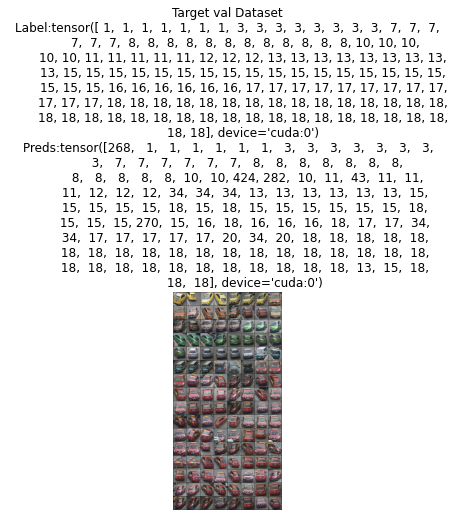

Accuracy Target Validation: tensor(0.8783, device='cuda:0')


In [ ]:
best_feature_extractor = FeatExt(pretrained_model)
best_classifier = ClfModel(list(pretrained_model.children())[-1].in_features)

checkpoint = torch.load(os.path.join(
    'content/MyDrive/vehicle-re-identification/training/model_checkpoints/checkpoint_source_model.pth'))
best_feature_extractor.load_state_dict(
    checkpoint['best_feature_extractor_state_dict'])
best_classifier.load_state_dict(checkpoint['best_classifier_state_dict'])

best_feature_extractor.to(device=c.device)
best_classifier.to(device=c.device)

best_feature_extractor.eval()
best_classifier.eval()

# source performance
corrects_count = 0.0
images_count = 0.0
for t, (Xs, ys) in enumerate(source_loader['test']):
  Xs = Xs.to(device=c.device)
  ys = ys.to(device=c.device)
  _, ys_pred = torch.max(F.softmax(
      best_classifier(best_feature_extractor(Xs)), dim=1), 1)
  corrects_count += torch.sum(ys_pred == ys.data)
  images_count += ys_pred.shape[0]
  title = 'Target val Dataset\nLabel:{}\nPreds:{}'.format(ys, ys_pred)
  out = make_grid(Xs)
  if t < 1:
    imshow(out, title, norm=False)
print('Accuracy Target Validation:', corrects_count/images_count)

# Training on Source and Target

In [ ]:
# Hyperparameters
c.alpha = 1.0 #5?  # C0, align loss
c.tloss = 1.0 # target cross entropy
c.sloss = 1.0 # source cross entropy
c.classifier_weight = 1.0
c.align_weight = 0.01
c.lr = 2e-3 # learning rate

In [ ]:
best_feature_extractor = FeatExt(pretrained_model)
best_classifier = ClfModel(list(pretrained_model.children())[-1].in_features)

checkpoint = torch.load(os.path.join(
    'content/MyDrive/vehicle-re-identification/training/model_checkpoints/checkpoint_source_model.pth'))
best_feature_extractor.load_state_dict(
    checkpoint['best_feature_extractor_state_dict'])
best_classifier.load_state_dict(checkpoint['best_classifier_state_dict'])

train_logger = DataLogger()
val_logger = DataLogger(val=True)

gamma_criterion = OtLoss(c.alpha, c.align_weight)
g_criterion = ClfLoss(c.classifier_weight, c.tloss, c.sloss, c.device)

optimizer = torch.optim.Adam(
    list(best_feature_extractor.parameters()) +
    list(best_classifier.parameters()),
    lr=c.lr)
num_epochs = 50
c.eval_every = 5
(target_best_fe_state_dict, target_best_cl_state_dict,
 target_train_logger, target_val_logger) = train_model_(
    best_feature_extractor, best_classifier, optimizer,
    SourceTargetIterator(source_loader['train'], target_loader['train']),
    process_target_one_epoch,
    SourceTargetIterator(source_loader['val'], target_loader['val']),
    num_epochs=num_epochs, gamma_criterion=gamma_criterion,
    g_criterion=g_criterion, save_to='mixed_model')

Epoch 0/49
Iter 50, Running Stats:
time=5.495368957519531 || examples_count=6528 || acc_source=3802 || acc_target=1228 || gamma_loss=143.61608231067657 || clf_loss=354.8924355506897 || loss=498.50852060317993
Iter 100, Running Stats:
time=10.584942102432251 || examples_count=12928 || acc_source=8705 || acc_target=2797 || gamma_loss=172.54098016023636 || clf_loss=626.0001997947693 || loss=798.541181564331
Epoch Results:
acc_source=0.6904891304347827 || acc_target=0.21956521739130436 || gamma_loss=0.01218601899707447 || clf_loss=0.04741364189464113 || loss=0.059599660984847855
----------
Epoch 1/49
Iter 50, Running Stats:
time=17.70806908607483 || examples_count=6528 || acc_source=5490 || acc_target=1492 || gamma_loss=24.785791963338852 || clf_loss=258.07562923431396 || loss=282.861421585083
Iter 100, Running Stats:
time=23.147713899612427 || examples_count=12928 || acc_source=10880 || acc_target=2831 || gamma_loss=47.218812346458435 || clf_loss=507.5604057312012 || loss=554.779219150543